In [4]:
import altair as alt
from functools import reduce
import gc
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pysqlcipher3 import dbapi2 as sqlcipher
#import seaborn as sns
import shapely

path = os.getcwd()
print('working dir: ' + path)
#/opt/dssg-hot/notebooks/shirley

working dir: /opt/dssg-hot/notebooks/shirley


# Get and compute trip data

#### Read in hot_2.1 db

In [2]:
# - $HOT_KEY exists in environment already
keynow = os.environ['HOT_KEY']
db = sqlcipher.connect('/opt/dssg-hot/data/shirleydata/sqldbs/hot_2.1.db')
db.execute('pragma key=\"x\''+keynow+'\'\"')

In [3]:
# - Test if the HOT_KEY password worked
db.execute('select * from census limit 1;').fetchall()

[(-9223314567028386566,
  1,
  'NEWCASTLE',
  'WA',
  98059,
  1,
  530330250051,
  33,
  25005,
  1031)]

In [5]:
# - Read in joined trip data
df = pd.read_sql_query("select trip_id, toll, entry_time, exit_time, entry_plaza, exit_plaza, is_hov, tag_id, acct, plate, id, plate_state, fips from trips_linked;", db)
#df.head()
#list(df.columns)
#df.shape
#df.dtypes
#df.isna().sum() # look at how many nans per column

In [ ]:
# - Change trip_id, tag_id, acct, plate, id to strings
# df['trip_id']=df['trip_id'].astype(str)
# df['tag_id']=df['tag_id'].astype(str)
# df['acct']=df['acct'].astype(str)
# df['plate']=df['plate'].astype(str)
# df['id']=df['id'].astype(str)
# df.dtypes

#### Join dist traveled, start/end mile posts, travel time, entry speed/volume w/ trips

In [6]:
# - Merge distance traveled + start/end mile posts for each trip
entry_exit_plu = pd.read_csv('/opt/dssg-hot/data/milepost_lookups/trips_entry_exit_summary.csv')
#entry_exit_plu['Count'] = entry_exit_plu['Count'].str.replace(',','').astype(int) # only need this if commas were in #s
entry_exit_plu['Percentage'] = entry_exit_plu['Percentage'].str.replace('%','').astype(float)
entry_exit_plu['Dist btwn entry & exit loop'] = abs(entry_exit_plu['Dist btwn entry & exit loop'])
entry_exit_plu.rename(columns={'Entry Plaza':'entry_plaza', 'Exit Plaza':'exit_plaza'}, inplace=True)

df = pd.merge(
    df, entry_exit_plu[['entry_plaza','exit_plaza','Actual entry mile post','Actual exit mile post','Dist btwn entry & exit loop']],
    how='left', on=['entry_plaza','exit_plaza']
)

In [ ]:
# # - Merge travel time + entry speed/volume for each trip 
# def roundarb(x, base):
#     return base * round(x/base)
# tt = pd.read_csv('../../data/shirleydata/TRACFLOW_travel_times/concatenated_405_travel_times_5am_to_8pm_5min.csv')
# tt.head()
# df['entry_time_5min']=roundarb(df['entry_time'], base=300).astype(int)
# pd.to_datetime(df['entry_time_5min'], unit='s')
# tt
# # for a, b in zip(df['entry_time'],roundarb(df['entry_time'])):
# #     print(a,b)

#### Compute categories (user frequency, user type, time of use, toll intervals)

<i>Commerical vs. private via number of tag_ids per id</i>

In [7]:
# --> id's w/ >6 diff tag_id's = commercial

# - Note that NA groups in groupby are automatically excluded
id_tagid_cts = df.groupby('id')['tag_id'].nunique()
comm_ids = id_tagid_cts[id_tagid_cts>6].index.values
df['is_commercial_by_num_tags'] = df['id'].isin(comm_ids).astype(int)
# - OR: # dfnc = df[~df['id'].isin(comm_ids)] # df, no commercial trips

# - Test:
# print(id_tagid_cts.sort_values(ascending=False))
# print(len(comm_ids))
# print(len(id_tagid_cts))
# print(id_tagid_cts[id_tagid_cts>6].index.values)
comm_ids_test = df[df['is_commercial_by_num_tags']==0].groupby('id')['tag_id'].nunique()
# - OR: # comm_ids_test = dfnc.groupby('id')['tag_id'].nunique()
print('Test commercial vs. private classification; following # should be zero: ' + str(comm_ids_test[comm_ids_test > 6].count())) # should be zero

# - Usage:
# Get df w/o commerical by num tags --> dfnew = df[df['is_commercial_by_num_tags']==0]

Test commercial vs. private classification; following # should be zero: 0


<i>Commerical vs. private via number of trips per id</i>

In [8]:
# --> id's w/ >10k trips = commercial

uf_id_cts = df['id'].value_counts() # counts how many times each value appears in the column = # of trips per id
comm_by_num_trips_ids = uf_id_cts[uf_id_cts>10000].index.values
df['is_commercial_by_num_trips'] = df['id'].isin(comm_by_num_trips_ids).astype(int)

# - Test:
#print(uf_id_cts.sort_values(ascending=False))
#print(len(comm_by_num_trips_ids))
#print(len(uf_id_cts))
#print(uf_id_cts[uf_id_cts>10000].index.values)
print('Test commerical vs. private classification by num of trips; following # should be zero: ' 
      + str(sum(df[df['is_commercial_by_num_trips']==0]['id'].value_counts() > 10000))) # should be zero

# - Usage:
# Get df w/o commerical by num trips --> dfnew = df[df['is_commercial_by_num_trips']==0]

Test commerical vs. private classification by num of trips; following # should be zero: 0


<i>Use frequency</i>

In [9]:
# --> defining 1 time users

otu_ids = uf_id_cts[uf_id_cts==1].index.values
df['is_otu'] = df['id'].isin(otu_ids).astype(int)

# - Test:
# print(uf_id_cts.sort_values(ascending=False))
# print(len(otu_ids))
# print(len(uf_id_cts))
# print(len(otu_ids)/len(uf_id_cts))
# print(uf_id_cts[uf_id_cts==1].index.values)
uf_ids_test = df[df['is_otu']==0]['id'].value_counts()
print('Test one-time use frequency classification; following # should be zero: ' + str(uf_ids_test[uf_ids_test==1].count())) # should be zero

# - Usage:
# Get df w/o one-time users --> dfnew = df[df['is_otu']==0]

Test one-time use frequency classification; following # should be zero: 0


<b>NUGGET: 399324/828983 = 48.17% accts are one time users</b>

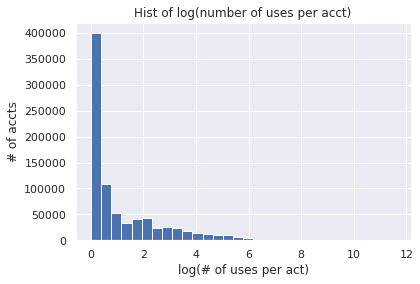

In [10]:
# #sns.set()
# plt.hist(np.log(uf_id_cts.values), bins=30);
# plt.title('Hist of log(number of uses per acct)');
# plt.xlabel('log(# of uses per act)');
# plt.ylabel('# of accts');

<i>Categorize trips by week day, month, time of day</i>

In [11]:
# --> trips occurring btwn 5-10am, 3-7pm are during the peak + are commuters
df['entry_time'] = pd.to_datetime(df['entry_time'],unit='s')
#df['exit_time'] = pd.to_datetime(df['exit_time'],unit='s')
#df['entry_day'] = df['entry_time'].apply(lambda t: t.weekday())
#df['entry_mon'] = df['entry_time'].apply(lambda t: t.month)
df['entry_hr'] = df['entry_time'].apply(lambda t: t.hour)

<i>Categorize northbound and southbound trips</i>

In [ ]:
# Just categorize northbound/southbound with entry_plaza

#### Decide on the characteristics you want to filter by for all following analyses

In [12]:
dfnow = df[(df['is_commercial_by_num_trips']==0) & (df['is_commercial_by_num_tags']==0)]

#### Group trips

In [13]:
# - Group all trips by fips, fips+hov/sov, fips+hov
fips_grouped = dfnow.groupby('fips')

#fips_sov_grouped = dfnow[dfnow['is_hov']==0].groupby('fips')
#fips_hov_grouped = dfnow[dfnow['is_hov']==1].groupby('fips')
# - OR:
#fips_shov_grouped = dfnow.groupby(['fips','is_hov'])

#### Compute plot variables

<i>Number of trips and users, HOV/SOV</i>

In [14]:
# - Count the number of unique trips (though they already are) from each cbg
fips_num_trips = fips_grouped['trip_id'].nunique()
#fips_num_trips = fips_grouped.count()['trip_id'] # alt method b/c trip_id is unique

# - Count the number of unique users from each cbg
fips_num_users = fips_grouped['id'].nunique()

# - Count the number of HOV trips from each cbg
#fips_num_trips_hov = fips_hov_grouped['trip_id'].nunique()
# - OR:
#fips_shov_now = fips_shov_grouped['trip_id'].nunique().reset_index(level='is_hov')
#fips_num_trips_hov = fips_shov_now[fips_shov_now['is_hov']==1]['trip_id']

# - Count the number of SOV trips from each cbg
#fips_num_trips_sov = fips_sov_grouped['trip_id'].nunique()

<i>Toll prices</i>

In [14]:
# - Get the avg toll paid by each cbg including HOV
fips_avg_toll_whov = fips_grouped.mean()['toll']

# - Get the avg toll paid by each cbg without HOV
#fips_avg_toll_wohov = fips_sov_grouped.mean()['toll']
# - OR:
#fips_shov_toll_now = fips_shov_grouped['toll'].mean().reset_index(level='is_hov')
#fips_avg_toll_wohov = fips_shov_toll_now[fips_shov_toll_now['is_hov']==0]['toll']

<i>Trip lengths</i>

In [14]:
# - Calc the avg distance traveled within each cbg
fips_avg_dist = fips_grouped.mean()['Dist btwn entry & exit loop']

<i>Usage times (time of day, weekday, month)</i>

In [57]:
# - Calc number of HOT trips during morning peak hours (5am-10am) in each cbg
fips_num_trips_m_peak = (dfnow[(dfnow['entry_hr']>=5) & (dfnow['entry_hr']<=9)]
                         .groupby('fips')
                        )['trip_id'].nunique()

# - Calc number of HOT trips during morning peak hours (5am-10am) heading northbound in each cbg
fips_num_trips_m_peak_nb = (dfnow[(dfnow['entry_hr']>=5) & (dfnow['entry_hr']<=9) & (dfnow['entry_plaza']<13)]
                         .groupby('fips')
                        )['trip_id'].nunique()

# - Calc number of HOT trips during morning peak hours (5am-10am) heading southbound in each cbg
fips_num_trips_m_peak_sb = (dfnow[(dfnow['entry_hr']>=5) & (dfnow['entry_hr']<=9) & (dfnow['entry_plaza']>=13)]
                         .groupby('fips')
                        )['trip_id'].nunique()

# - Calc number of HOT trips during afternoon/evening peak hours (3pm-7pm) in each cbg
fips_num_trips_e_peak = (dfnow[(dfnow['entry_hr']>=15) & (dfnow['entry_hr']<=19)]
                         .groupby('fips')
                        )['trip_id'].nunique()

# - Calc number of HOT trips during afternoon/evening peak hours (3pm-7pm) heading northbound in each cbg
fips_num_trips_e_peak_nb = (dfnow[(dfnow['entry_hr']>=15) & (dfnow['entry_hr']<=19) & (dfnow['entry_plaza']<13)]
                         .groupby('fips')
                        )['trip_id'].nunique()

# - Calc number of HOT trips during afternoon/evening peak hours (3pm-7pm) heading southbound in each cbg
fips_num_trips_e_peak_sb = (dfnow[(dfnow['entry_hr']>=15) & (dfnow['entry_hr']<=19) & (dfnow['entry_plaza']>=13)]
                         .groupby('fips')
                        )['trip_id'].nunique()

<i>Usage frequencies</i>

In [18]:
# - Calc number of one time HOT lane users within each cbg
fips_num_trips_otu = (dfnow[dfnow['is_otu']==1].groupby('fips'))['trip_id'].nunique()

In [ ]:
# - Calc % of one time HOT users within each cbg

# - Calc % of all users that use the HOT lanes once in each cbg

In [ ]:
# - Calc % of trips within each cbg paying <$1 toll
#fips_num_trips = fips_grouped['trip_id'].nunique()

In [ ]:
# - Calc % of users within each cbg paying <$1 toll

In [ ]:
# - Calc % of all users paying <$1 toll in each cbg

In [ ]:
# - Calc % of all users that use the HOT lanes once in each cbg

In [ ]:
# - Calc % of trips within each cbg that are carpool

In [ ]:
# - Calc % of all trips that are carpool in each cbg

# Join calculated values and ACS info to cbg shapefile by fips

#### Load Census bg shapefile and ACS 2016 info

In [62]:
# - Load census block groups
cbgs = gpd.read_file('/opt/dssg-hot/data/shapefiles/block_groups/block_groups.shp')
cbgs.rename(columns={'fips_code':'fips'}, inplace=True)
cbgs['fips'] = pd.to_numeric(cbgs['fips'])
#cbgs.dtypes
#cbgs.head()

In [63]:
# - Load ACS 2016 info
acs = pd.read_sql_query("select fips_code as fips, med_inc, population, race_nonhisp_white, race_nonhisp_asian, trans_carpool, trans_drivealone, trans_transit from acs;", db)
cols = acs.columns.drop(['fips','population'])
acs[cols] = acs[cols].apply(pd.to_numeric, errors='coerce')
acs.dtypes

fips                    int64
med_inc               float64
population              int64
race_nonhisp_white    float64
race_nonhisp_asian    float64
trans_carpool         float64
trans_drivealone      float64
trans_transit         float64
dtype: object

#### Join bg shapefile, ACS 2016 info, and computed plot variables

<i>ACS info</i>

In [77]:
cbgs_join = cbgs.merge(acs, on='fips')

<i>Number of trips and users, HOV/SOV</i>

In [65]:
# https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns

# cbgs_join = cbgs_join.merge(fips_num_trips, on='fips').merge(fips_num_users, on='fips')
# cbgs_join.rename(columns={'trip_id':'num_trips', 'id':'num_users'}, inplace=True)

# cbgs_join['num_trips_pc'] = cbgs_join['num_trips']/cbgs_join['population']

# cbgs_join = cbgs_join.merge(fips_num_trips_hov, on='fips')
# cbgs_join.rename(columns={'trip_id':'num_trips_hov'}, inplace=True)

# cbgs_join = cbgs_join.merge(fips_num_trips_sov, on='fips')
# cbgs_join.rename(columns={'trip_id':'num_trips_sov'}, inplace=True)

# cbgs_join['frac_trips_hov'] = cbgs_join['num_trips_hov']/cbgs_join['num_trips']

# cbgs_join['frac_trips_sov'] = cbgs_join['num_trips_sov']/cbgs_join['num_trips']

<i>Toll prices</i>

In [65]:
# # cbgs_join.drop(columns=['toll_y'],inplace=True)

# cbgs_join = cbgs_join.merge(fips_avg_toll_whov, on='fips')
# cbgs_join.rename(columns={'toll':'avg_toll_whov'}, inplace=True)

# cbgs_join = cbgs_join.merge(fips_avg_toll_wohov, on='fips')
# cbgs_join.rename(columns={'toll':'avg_toll_wohov'}, inplace=True)

<i>Trip lengths</i>

In [65]:
# cbgs_join = cbgs_join.merge(fips_avg_dist, on='fips')
# cbgs_join.rename(columns={'Dist btwn entry & exit loop':'avg_dist'}, inplace=True)

<i>Usage times (time of day, weekday, month)</i>

In [65]:
# cbgs_join = cbgs_join.merge(fips_num_trips_m_peak, on='fips')
# cbgs_join.rename(columns={'trip_id':'num_trips_m_peak'}, inplace=True)

# cbgs_join = cbgs_join.merge(fips_num_trips_m_peak_nb, on='fips')
# cbgs_join.rename(columns={'trip_id':'num_trips_m_peak_nb'}, inplace=True)

# cbgs_join = cbgs_join.merge(fips_num_trips_m_peak_sb, on='fips')
# cbgs_join.rename(columns={'trip_id':'num_trips_m_peak_sb'}, inplace=True)

# cbgs_join = cbgs_join.merge(fips_num_trips_e_peak, on='fips')
# cbgs_join.rename(columns={'trip_id':'num_trips_e_peak'}, inplace=True)

# cbgs_join = cbgs_join.merge(fips_num_trips_e_peak_nb, on='fips')
# cbgs_join.rename(columns={'trip_id':'num_trips_e_peak_nb'}, inplace=True)

# cbgs_join = cbgs_join.merge(fips_num_trips_e_peak_sb, on='fips')
# cbgs_join.rename(columns={'trip_id':'num_trips_e_peak_sb'}, inplace=True)

<i>Usage frequencies</i>

In [65]:
# cbgs_join = cbgs_join.merge(fips_num_trips_otu, on='fips')
# cbgs_join.rename(columns={'trip_id':'num_trips_otu'}, inplace=True)

<i>Convert from gpd df to pd df</i>

In [65]:
# - For some applications below, need cbgs_join as a pandas dataframe, rather than a gpd dataframe;
# will also need centroids of block groups

# cbgs_join_df = pd.DataFrame(cbgs_join.drop(columns='geometry'))
# cbgs_join_df['lon'] = cbgs_join['geometry'].centroid.x
# cbgs_join_df['lat'] = cbgs_join['geometry'].centroid.y
# #print(type(cbgs_join_df))
# #print(cbgs_join_df.dtypes)

# Load in shapefiles for drawing maps

#### Load in toll points shapefile

In [36]:
tollptsnb = gpd.read_file('/opt/dssg-hot/data/shapefiles/toll_pts_405/northbound_405_toll_pts.shp')
#print(tollptsnb.crs)
#print(tollptsnb.head())

majtpsnb = tollptsnb[(tollptsnb['Name']=='NB Entry 1 (entry plaza = NB1 aka 3)')
                |(tollptsnb['Name']=='NB Exit 7 (exit plaza = NB10 aka 12)')]
#majtpsnb.plot()

In [37]:
tollptssb = gpd.read_file('/opt/dssg-hot/data/shapefiles/toll_pts_405/southbound_405_toll_pts.shp')
#print(tollptssb.crs)
#print(tollptssb.head())

majtpssb = tollptssb[(tollptssb['Name']=='SB Entry 1 (entry plaza = SB1 aka 13)')
                |(tollptssb['Name']=='SB Exit 7 (exit plaza = SB10 aka 23)')]
#majtpssb.plot()

#### Load in city points shapefile

In [39]:
citypts = gpd.read_file('/opt/dssg-hot/data/shapefiles/city_points/city_points.shp')
#print(citypts.crs)
citypts['geometry'] = citypts['geometry'].to_crs(epsg=4326)
#print(citypts.head())

#majcps = citypts[(citypts['MajorCity']=='yes')]
majcps = citypts[(citypts['NAME']=='Seattle')|(citypts['NAME']=='Bellevue')
                 |(citypts['NAME']=='Lynnwood')|(citypts['NAME']=='Woodinville')
                 |(citypts['NAME']=='Bothell')|(citypts['NAME']=='Shoreline')
                 |(citypts['NAME']=='Edmonds')|(citypts['NAME']=='Redmond')
                 |(citypts['NAME']=='Kirkland')|(citypts['NAME']=='Renton')
                 |(citypts['NAME']=='Kent')|(citypts['NAME']=='Issquah')
                 |(citypts['NAME']=='Everett')|(citypts['NAME']=='SeaTac')]
# ax = majcps.plot()
# for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
#     ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

#### Load in roads shapefile

In [40]:
rds500k = gpd.read_file('/opt/dssg-hot/data/shapefiles/roads500k/sr500k_20181231.shp')
#print(rds500k.crs)
rds500k['geometry'] = rds500k['geometry'].to_crs(epsg=4326)
#print(rds500k.head())

majrds = rds500k[(rds500k['StateRoute']=='405')|(rds500k['StateRoute']=='005')
                |(rds500k['StateRoute']=='522')|(rds500k['StateRoute']=='520')
                |(rds500k['StateRoute']=='527')|(rds500k['StateRoute']=='90')]
#majrds.plot()

# Extras

In [ ]:
# # - Calc number of HOT trips during morning peak hours (5am-10am) in each cbg
# fips_hrs_now = fips_hr_grouped['trip_id'].count().reset_index(level='entry_hr')
# fips_num_trips_morning_peak = fips_hrs_now[(fips_hrs_now['entry_hr']>=5) & (fips_hrs_now['entry_hr']<=9)]['trip_id']

# test = fips_hr_grouped['trip_id'].count().to_frame().query('entry_hr >= 5 and entry_hr <= 9')
# #.reset_index('entry_hr')